In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import qutip
import numpy as np
import qutip
import scqubits
from scipy.optimize import minimize
from IPython.display import clear_output

from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

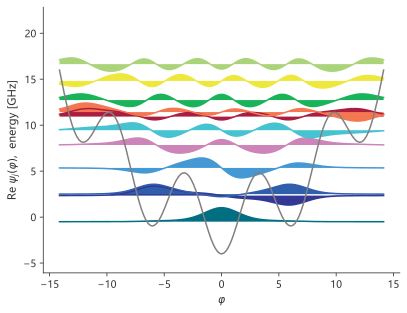

In [2]:
EJ = 4
EC = EJ/2
EL = EJ/25

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=13)

t_duration = 50
tlist = np.linspace(0,t_duration,t_duration)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(10)]
qbt.fluxonium.plot_wavefunction(which=[0,1,2,3,4,5,6,7,8,9,10])

 /home/kai/miniconda3/envs/test/lib/python3.10/site-packages/CoupledQuantumSystems/IFQ.py: 63

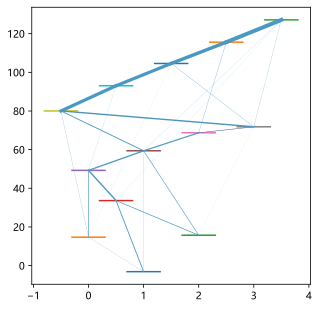

In [4]:
def visualize_c_ops(c_ops,evals):
    level_to_x = {
        0:1,
        1:0,
        2:2,
        3:0.5,
        4:0,
        5:1,
        6:2,
        7:3,
        8:-0.5,
        9:0.5,
        10:1.5,
        11:2.5,
        12:3.5,
    }
    def plot_levels(ax):
        for ql,eval in enumerate(evals):
            eval_with_2pi = 2*np.pi*eval
            x = level_to_x[ql]
            length = 0.3
            ax.plot([x-length,x+length], [eval_with_2pi,eval_with_2pi])
    def plot_thermalization(ax):
        max_element = np.max(np.abs(np.square((c_ops.full()))))
        max_lw = 4
        lw_scaling_ratio = max_lw/max_element
        decay_color = '#4999c3'
        heating_color = '#d5373d'
        for i in range(len(evals)):
            for j in range(len(evals)):
                if i == j:
                    continue
                else:
                    i_y = 2*np.pi*evals[i]
                    j_y = 2*np.pi*evals[j]
                    i_x = level_to_x[i]
                    j_x = level_to_x[j]
                    ax.plot([i_x,j_x], [i_y,j_y], color = decay_color if i < j else heating_color, lw =lw_scaling_ratio* np.abs(np.square((c_ops[i,j])))  )
    fig, ax = plt.subplots(1,1,figsize = (5,5))
    plot_levels(ax)
    plot_thermalization(ax)
    return fig
temp_in_mK = 20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6
c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
evals = qbt.fluxonium.eigenvals(evals_count=qbt.truncated_dim)

fig  = visualize_c_ops(c_ops,evals)

[1.94021385 2.1250137 ]


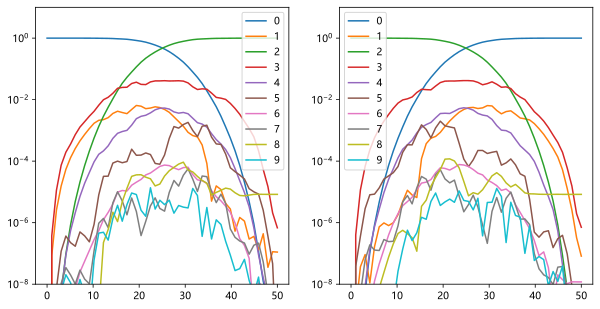

(9.137691280303173e-06, 9.182617228042922e-06)


In [5]:
def objective(x):
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]

    detuning1 =0.3
    detuning2 =0.3

    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_DRAG_drive_terms(
            i = 0,
            j = 3,
            k = 2,
            detuning1=detuning1,
            detuning2 = detuning2,
            t_duration=t_duration,
            shape='sin^2',
            amp_scaling_factor = 1,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
            amp1_correction_scaling_factor = 0,
            amp2_correction_scaling_factor = 0,
        ),
        # c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()

    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

initial_guess =[2.0,2.0]


result = minimize(objective, initial_guess, method='Nelder-Mead')


[1.94021385, 2.1250137]


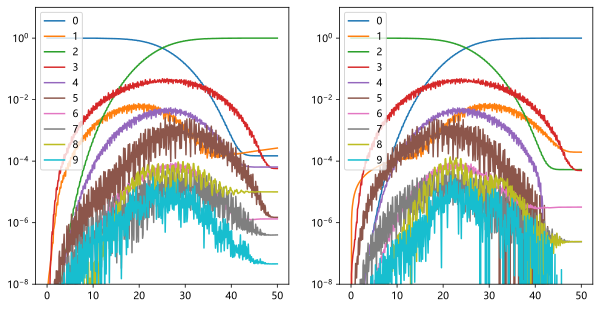

(0.00028918453337112293, 7.083743268376796e-05)


In [7]:
x = [1.94021385 ,2.1250137 ]

tlist = np.linspace(0,t_duration,t_duration*10)



amp1_scaling_factor = x[0]
amp2_scaling_factor = x[1]

detuning1 =0.3
detuning2 =0.3

results  = qbt.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
    tlist = tlist,
    drive_terms = qbt.get_Raman_DRAG_drive_terms(
        i = 0,
        j = 3,
        k = 2,
        detuning1=detuning1,
        detuning2 = detuning2,
        t_duration=t_duration,
        shape='sin^2',
        amp_scaling_factor = 1,
        amp1_scaling_factor = amp1_scaling_factor,
        amp2_scaling_factor = amp2_scaling_factor,
        amp1_correction_scaling_factor = 0,
        amp2_correction_scaling_factor = 0,
    ),
    c_ops = c_ops,
    e_ops = e_ops
)
clear_output()
print(x)
fig, axes = plt.subplots(1,2,figsize = (10,5))
for i, exp in enumerate(results[0].expect):
    axes[0].plot(tlist,exp,label= f"{i}")
for i, exp in enumerate(results[1].expect):
    axes[1].plot(tlist,exp,label= f"{i}")
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_ylim(1e-8,1e1)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-8,1e1)
plt.show()

one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
print((one_minus_pop2, one_minus_pop0))


# optimize with decay

[1.94122708 2.12431938]


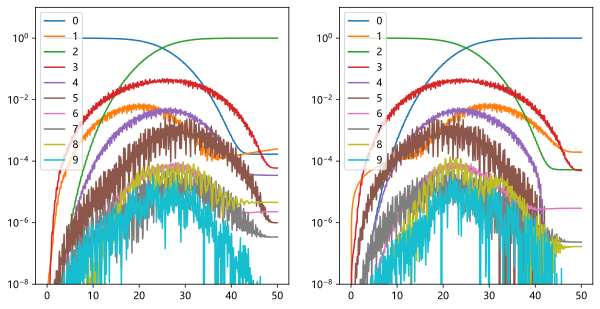

(0.0002759935244203149, 6.814334996607663e-05)


In [8]:
def objective(x):
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]

    detuning1 =0.3
    detuning2 =0.3

    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_DRAG_drive_terms(
            i = 0,
            j = 3,
            k = 2,
            detuning1=detuning1,
            detuning2 = detuning2,
            t_duration=t_duration,
            shape='sin^2',
            amp_scaling_factor = 1,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
            amp1_correction_scaling_factor = 0,
            amp2_correction_scaling_factor = 0,
        ),
        c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()

    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

initial_guess = [1.94021385 ,2.1250137 ]


result = minimize(objective, initial_guess, method='Nelder-Mead')


In [ ]:
x = [1.94021385 ,2.1250137 ]

tlist = np.linspace(0,t_duration,t_duration*10)



amp1_scaling_factor = x[0]
amp2_scaling_factor = x[1]

detuning1 =0.3
detuning2 =0.3

results  = qbt.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
    tlist = tlist,
    drive_terms = qbt.get_Raman_DRAG_drive_terms(
        i = 0,
        j = 3,
        k = 2,
        detuning1=detuning1,
        detuning2 = detuning2,
        t_duration=t_duration,
        shape='sin^2',
        amp_scaling_factor = 1,
        amp1_scaling_factor = amp1_scaling_factor,
        amp2_scaling_factor = amp2_scaling_factor,
        amp1_correction_scaling_factor = 0,
        amp2_correction_scaling_factor = 0,
    ),
    c_ops = c_ops,
    e_ops = e_ops
)
clear_output()
print(x)
fig, axes = plt.subplots(1,2,figsize = (10,5))
for i, exp in enumerate(results[0].expect):
    axes[0].plot(tlist,exp,label= f"{i}")
for i, exp in enumerate(results[1].expect):
    axes[1].plot(tlist,exp,label= f"{i}")
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_ylim(1e-8,1e1)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-8,1e1)
plt.show()

one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
print((one_minus_pop2, one_minus_pop0))
